In [1]:
import pandas as pd
import numpy as np
import seaborn
import yfinance as yf


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
import joblib
from keras.models import load_model

# Carregar modelos LSTM
modelo1 = load_model('models_1/modelo_disney_lstm.h5', compile=False)


# Carregar scalers
scaler1 = joblib.load('data/scaler.pkl')


In [2]:
symbol='DIS'
start_date='2018-01-01'
end_date='2024-07-20'

df_original = yf.download(
            symbol, 
            start=start_date, 
            end=end_date,
            progress=True
        )
        
print(f"Dados baixados: {len(df_original)} dias de negociação")
print(f"Colunas disponíveis: {list(df_original.columns)}")

/var/folders/vl/2xv77p5n31xclsdwyq7kgg3r0000gn/T/ipykernel_48524/3136357432.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_original = yf.download(
[*********************100%***********************]  1 of 1 completed

Dados baixados: 1647 dias de negociação
Colunas disponíveis: [('Close', 'DIS'), ('High', 'DIS'), ('Low', 'DIS'), ('Open', 'DIS'), ('Volume', 'DIS')]


In [2]:
### Testando exemplo do Challenge
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-01-01'

df = yf.download(symbol, start=start_date, end=end_date)

/var/folders/vl/2xv77p5n31xclsdwyq7kgg3r0000gn/T/ipykernel_2646/1621691815.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [3]:
df.columns

# df.head(25)
# df.describe()
# df.info()

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [4]:
close_prices = df.xs('Close', axis=1, level='Price')
open_prices = df.xs('Open', axis=1, level='Price')
volume = df.xs('Volume', axis=1, level='Price')

if isinstance(close_prices, pd.DataFrame):
    close_prices = close_prices.iloc[:, 0]

print(close_prices.head())

Date
2020-01-02    72.468254
2020-01-03    71.763718
2020-01-06    72.335556
2020-01-07    71.995346
2020-01-08    73.153503
Name: AAPL, dtype: float64


In [5]:
df.columns = df.columns.get_level_values(0)
close_prices = df['Close']
open_prices = df['Open']
volume = df['Volume']

print(df.head(15))

Price           Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.468254  72.528574  71.223252  71.476592  135480400
2020-01-03  71.763718  72.523746  71.539330  71.696160  146322800
2020-01-06  72.335556  72.374162  70.634539  70.885472  118387200
2020-01-07  71.995346  72.600952  71.775781  72.345197  108872000
2020-01-08  73.153503  73.455103  71.698589  71.698589  132079200
2020-01-09  74.707329  74.900349  73.879742  74.130668  170108400
2020-01-10  74.876244  75.440844  74.374386  74.941394  140644800
2020-01-13  76.475922  76.502466  75.074089  75.192321  121532000
2020-01-14  75.443245  76.623105  75.320197  76.413193  161954400
2020-01-15  75.119926  76.123650  74.688034  75.242981  121923600
2020-01-16  76.060921  76.171915  75.300892  75.662811  108829200
2020-01-17  76.903000  76.905408  76.003025  76.309447  137816400
2020-01-21  76.381805  76.972935  76.244274  76.531397  110843200
2020-01-22

In [6]:
precos = df['Close'].values.reshape(-1, 1)

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
precos_normalizados = scaler.fit_transform(precos)
print(precos_normalizados)

[[0.12820362]
 [0.12324182]
 [0.12726907]
 ...
 [0.96539536]
 [0.96839559]
 [0.96106979]]


In [8]:
tamanho_treino = int(len(precos_normalizados) * 0.8)

dados_treino = precos_normalizados[:tamanho_treino]
dados_teste = precos_normalizados[tamanho_treino:]

In [9]:
def criar_sequencias(df, janela_tempo=60):
    X, Y = [], []
    for i in range(janela_tempo, len(df)):
        X.append(df[i-janela_tempo:i, 0])
        Y.append(df[i, 0])
    return np.array(X), np.array(Y)

janela = 60
X_treino, Y_treino = criar_sequencias(dados_treino, janela)
X_teste, Y_teste = criar_sequencias(dados_teste, janela)

In [10]:
print(f"Conjunro Treino - {dados_treino}")
print(f"Conjunto Teste - {dados_teste}")

Conjunro Treino - [[0.12820362]
 [0.12324182]
 [0.12726907]
 [0.1248731 ]
 [0.13302958]
 [0.14397262]
 [0.14516222]
 [0.15642818]
 [0.14915541]
 [0.14687839]
 [0.15350548]
 [0.15943594]
 [0.15576535]
 [0.15768559]
 [0.16028537]
 [0.15872201]
 [0.14281734]
 [0.15766851]
 [0.16896858]
 [0.16816992]
 [0.14376876]
 [0.14232431]
 [0.15963974]
 [0.16405783]
 [0.17044694]
 [0.16293555]
 [0.16552426]
 [0.16222007]
 [0.17514798]
 [0.17117924]
 [0.1713155 ]
 [0.16118112]
 [0.16905025]
 [0.16339522]
 [0.15104658]
 [0.12571882]
 [0.1085158 ]
 [0.11629971]
 [0.08371606]
 [0.08344353]
 [0.12679194]
 [0.11062775]
 [0.13348581]
 [0.11675949]
 [0.1101338 ]
 [0.07119698]
 [0.10384866]
 [0.08696926]
 [0.04064017]
 [0.09129547]
 [0.03038643]
 [0.04852631]
 [0.03798304]
 [0.03476379]
 [0.00829498]
 [0.        ]
 [0.03834078]
 [0.03602432]
 [0.05803061]
 [0.0398056 ]
 [0.05184772]
 [0.05096202]
 [0.02817212]
 [0.03501931]
 [0.02902381]
 [0.06489473]
 [0.0597168 ]
 [0.07102666]
 [0.07429695]
 [0.08325607]
 [

In [11]:
X_treino = X_treino.reshape(X_treino.shape[0], X_treino.shape[1], 1)
X_teste = X_teste.reshape(X_teste.shape[0], X_teste.shape[1], 1)

In [12]:
model = Sequential([
LSTM(units=50, return_sequences=True, input_shape=(janela, 1)),
Dropout(0.2),
# Segunda Camada
LSTM(units=50, return_sequences=True),
Dropout(0.2),
# Terceira Camada
LSTM(units=50),
Dropout(0.2),
# Camada de saída
Dense(units=1)
])

model.compile(optimizer = 'adam', loss='mean_squared_error')

model.summary()

/Users/isabellaluna/Desktop/Pos_Tech/Tech-Challenges/tech_challenge_4/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0622 - val_loss: 0.0050
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054 - val_loss: 0.0077
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047 - val_loss: 0.0078
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

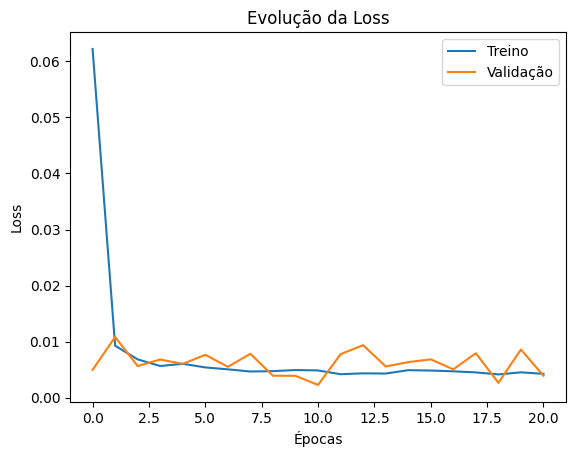

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)


historico = model.fit(
    X_treino, Y_treino,
    epochs=50, 
    batch_size= 32,
    validation_data=(X_teste, Y_teste),
    callbacks=[early_stop],
    verbose=1
)

plt.plot(historico.history['loss'], label='Treino')
plt.plot(historico.history['val_loss'], label='Validação')
plt.title('Evolução da Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
previsoes = model.predict(X_teste)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [15]:
previsoes_reais = scaler.inverse_transform(previsoes)
y_teste_real = scaler.inverse_transform(Y_teste.reshape(-1, 1))

In [16]:
mse = mean_squared_error(y_teste_real, previsoes_reais)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_teste_real, previsoes_reais)
r2 = r2_score(y_teste_real, previsoes_reais)

print("=== Métricas de Avaliação ===")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root MSE): ${rmse:.2f}")
print(f"MAE (Mean Absolute Error): ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

# MAPE - Erro Percentual Médio Absoluto
mape = np.mean(np.abs((y_teste_real - previsoes_reais) / y_teste_real)) * 100
print(f"MAPE: {mape:.2f}%")

=== Métricas de Avaliação ===
MSE (Mean Squared Error): 79.0925
RMSE (Root MSE): $8.89
MAE (Mean Absolute Error): $7.72
R² Score: -0.2255
MAPE: 4.17%


In [17]:
def diagnosticar_modelo(y_real, y_pred):
    """
    Diagnóstico completo do que está errado
    """
    
    # 1. O modelo está prevendo valores constantes?
    variancia_pred = np.var(y_pred)
    variancia_real = np.var(y_real)
    
    print("DIAGNÓSTICO DO MODELO")
    print("="*40)
    
    if variancia_pred < variancia_real * 0.1:
        print("❌ PROBLEMA: Modelo está prevendo valores quase constantes!")
        print(f"   Variância previsões: {variancia_pred:.2f}")
        print(f"   Variância real: {variancia_real:.2f}")
    
    # 2. Verificar se está defasado no tempo (lag)
    # Calcular correlação com lag
    correlacao_sem_lag = np.corrcoef(y_real[1:].flatten(), y_pred[:-1].flatten())[0,1]
    correlacao_com_lag = np.corrcoef(y_real[:-1].flatten(), y_pred[1:].flatten())[0,1]
    
    if correlacao_com_lag > correlacao_sem_lag:
        print("❌ PROBLEMA: Modelo está prevendo com atraso (lag)!")
        print("   Está basicamente repetindo o valor anterior")
    
    # 3. Verificar tendência
    tendencia_real = np.polyfit(range(len(y_real)), y_real.flatten(), 1)[0]
    tendencia_pred = np.polyfit(range(len(y_pred)), y_pred.flatten(), 1)[0]
    
    if np.sign(tendencia_real) != np.sign(tendencia_pred):
        print("❌ PROBLEMA: Modelo está prevendo tendência oposta!")
    
    # 4. Visualizar para entender
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Série temporal
    axes[0,0].plot(y_real, label='Real', alpha=0.7)
    axes[0,0].plot(y_pred, label='Previsto', alpha=0.7)
    axes[0,0].set_title('Comparação Temporal')
    axes[0,0].legend()
    
    # Plot 2: Primeiros 50 pontos (zoom)
    axes[0,1].plot(y_real[:50], 'o-', label='Real', alpha=0.7)
    axes[0,1].plot(y_pred[:50], 's-', label='Previsto', alpha=0.7)
    axes[0,1].set_title('Zoom - Primeiros 50 pontos')
    axes[0,1].legend()
    
    # Plot 3: Scatter
    axes[1,0].scatter(y_real, y_pred, alpha=0.5)
    axes[1,0].plot([y_real.min(), y_real.max()], 
                   [y_real.min(), y_real.max()], 'r--')
    axes[1,0].set_title('Scatter Plot')
    axes[1,0].set_xlabel('Real')
    axes[1,0].set_ylabel('Previsto')
    
    # Plot 4: Distribuições
    axes[1,1].hist(y_real, alpha=0.5, label='Real', bins=30)
    axes[1,1].hist(y_pred, alpha=0.5, label='Previsto', bins=30)
    axes[1,1].set_title('Distribuição dos Valores')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

DIAGNÓSTICO DO MODELO
❌ PROBLEMA: Modelo está prevendo com atraso (lag)!
   Está basicamente repetindo o valor anterior


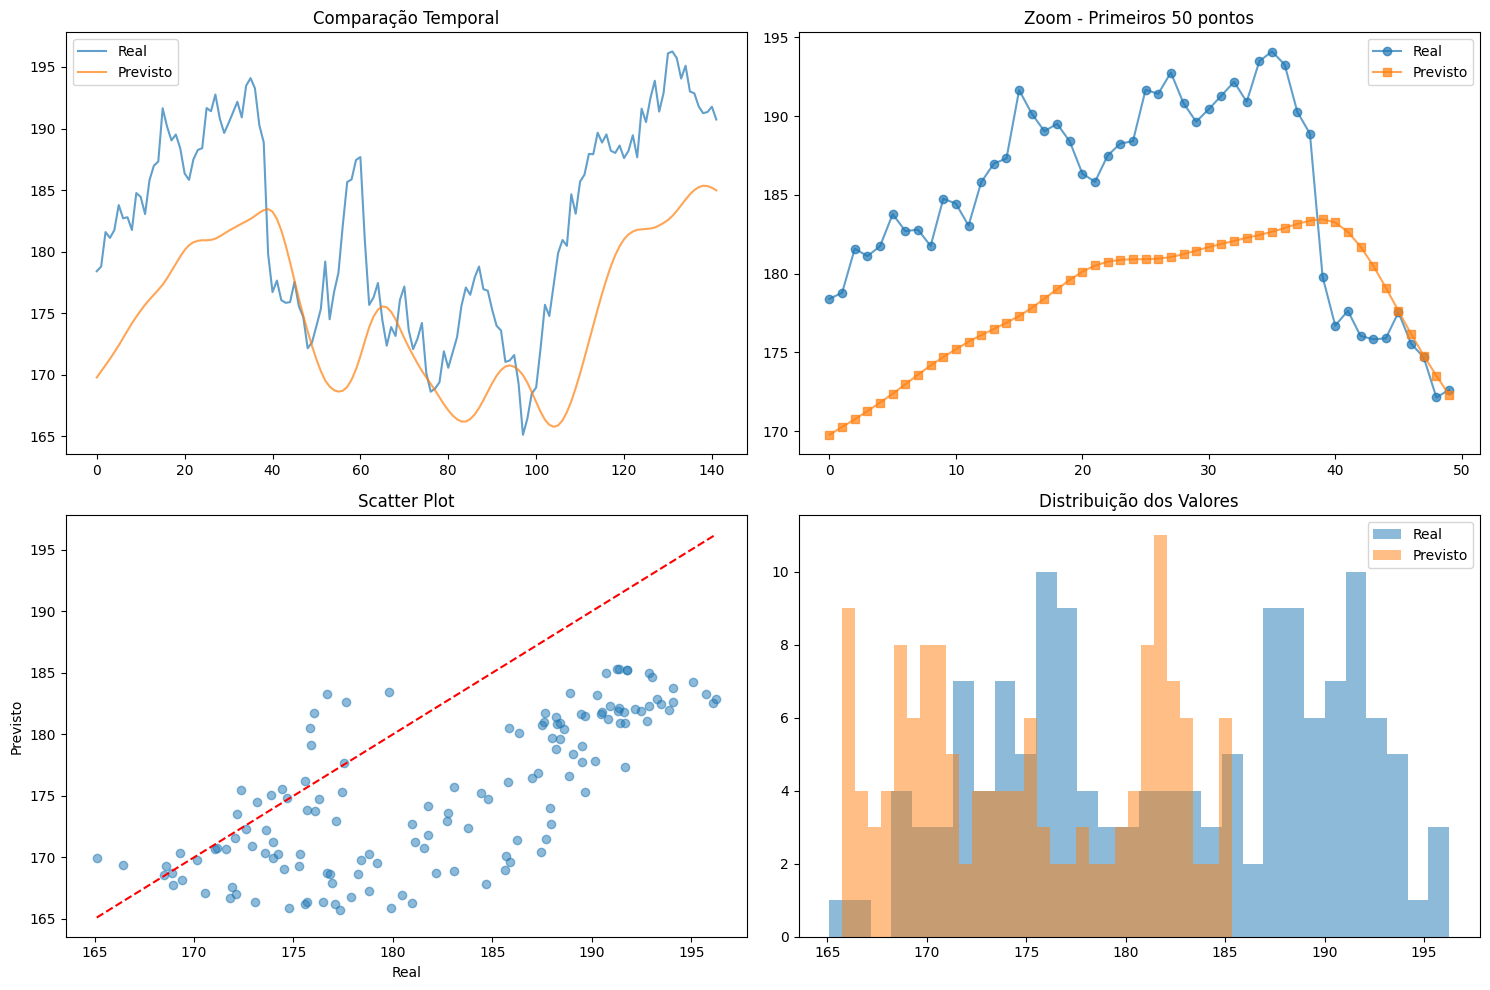

In [18]:
# Executar diagnóstico
diagnosticar_modelo(y_teste_real, previsoes_reais)

In [22]:
def preparar_dados_sem_lag(dados, janela=60):
    """
    Prepara dados usando retornos percentuais para evitar lag
    """
    # Calcular retornos percentuais
    precos = dados['Close'].values
    retornos = np.diff(precos) / precos[:-1]  # Retorno percentual
    
    # Alternativa: usar log-retornos (mais estável)
    # retornos = np.diff(np.log(precos))
    
    # Normalizar retornos
    scaler = MinMaxScaler(feature_range=(-1, 1))  # -1 a 1 para retornos
    retornos_norm = scaler.fit_transform(retornos.reshape(-1, 1))
    
    # Criar sequências
    X, y = [], []
    for i in range(janela, len(retornos_norm)):
        X.append(retornos_norm[i-janela:i, 0])
        y.append(retornos_norm[i, 0])
    
    return np.array(X), np.array(y), scaler, precos

In [23]:
# Aplicar a solução
X_novo, y_novo, scaler_retornos, precos_originais = preparar_dados_sem_lag(df)

In [26]:
def treinar_modelo_sem_lag(dados, ticker='AAPL'):
    """
    Pipeline completo para evitar lag
    """
    print("Preparando dados anti-lag...")
    
    # 1. Calcular retornos ao invés de preços
    precos = dados['Close'].values
    retornos = np.diff(np.log(precos))  # log-retornos
    
    # 2. Adicionar features adicionais
    volume_change = np.diff(np.log(dados['Volume'].values + 1))
    high_low_spread = (dados['High'].values[1:] - dados['Low'].values[1:]) / dados['Close'].values[1:]
    
    # 3. Combinar features
    features = np.column_stack([retornos, volume_change, high_low_spread])
    
    # 4. Normalizar
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features_norm = scaler.fit_transform(features)
    
    # 5. Criar sequências
    janela = 60
    X, y = [], []
    for i in range(janela, len(features_norm)):
        X.append(features_norm[i-janela:i])
        y.append(features_norm[i, 0])  # Prever retorno
    
    X = np.array(X)
    y = np.array(y)
    
    # 6. Split treino/teste
    split = int(0.8 * len(X))
    X_treino, X_teste = X[:split], X[split:]
    y_treino, y_teste = y[:split], y[split:]
    
    # 7. Criar modelo
    modelo = Sequential([
        LSTM(100, return_sequences=True, input_shape=(janela, 3)),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1, activation='tanh')  # tanh para retornos
    ])
    
    modelo.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # 8. Treinar

    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
    ]
    
    historico = modelo.fit(
        X_treino, y_treino,
        epochs=100,
        batch_size=32,
        validation_data=(X_teste, y_teste),
        callbacks=callbacks,
        verbose=1
    )
    
    return modelo, scaler, X_teste, y_teste, precos


In [27]:

# Executar
modelo_novo, scaler, X_teste, y_teste, precos_orig = treinar_modelo_sem_lag(df)

# Avaliar se ainda tem lag
def verificar_lag(y_real, y_pred):
    # Calcular autocorrelação
    corr_sem_lag = np.corrcoef(y_real[1:], y_pred[:-1])[0,1]
    corr_com_lag = np.corrcoef(y_real[:-1], y_pred[1:])[0,1]
    
    print(f"Correlação sem lag: {corr_sem_lag:.3f}")
    print(f"Correlação com lag: {corr_com_lag:.3f}")
    
    if corr_com_lag > corr_sem_lag:
        print("⚠️ Ainda há lag!")
    else:
        print("✅ Lag resolvido!")

previsoes = modelo_novo.predict(X_teste)
verificar_lag(y_teste, previsoes.flatten())

Preparando dados anti-lag...
Epoch 1/100


/Users/isabellaluna/Desktop/Pos_Tech/Tech-Challenges/tech_challenge_4/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0297 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0271 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0268 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0276 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0268 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0271 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0269 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0265 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0271 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 10/100
24/24 ━━━

In [28]:
mse = mean_squared_error(y_teste, previsoes)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_teste, previsoes)
r2 = r2_score(y_teste, previsoes)

print("=== Métricas de Avaliação ===")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root MSE): ${rmse:.2f}")
print(f"MAE (Mean Absolute Error): ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

# MAPE - Erro Percentual Médio Absoluto
mape = np.mean(np.abs((y_teste - previsoes) / y_teste)) * 100
print(f"MAPE: {mape:.2f}%")

=== Métricas de Avaliação ===
MSE (Mean Squared Error): 0.0088
RMSE (Root MSE): $0.09
MAE (Mean Absolute Error): $0.07
R² Score: -0.0040
MAPE: 148.31%


In [30]:
# Para RETORNOS, as métricas têm escala diferente
def interpretar_metricas_retornos(mse, rmse, mae, r2, mape):
    print("\n📈 INTERPRETAÇÃO PARA MODELO DE RETORNOS")
    print("="*50)
    
    # Para retornos normalizados entre -1 e 1
    if rmse < 0.1:
        print(f"RMSE: {rmse:.4f} - Excelente para retornos")
    elif rmse < 0.3:
        print(f"RMSE: {rmse:.4f} - Bom para retornos")
    elif rmse < 0.5:
        print(f"RMSE: {rmse:.4f} - Razoável para retornos")
    else:
        print(f"RMSE: {rmse:.4f} - Ruim para retornos")
    
    # R² para séries financeiras
    if r2 > 0.1:
        print(f"R²: {r2:.4f} - Muito bom para mercado financeiro!")
    elif r2 > 0.01:
        print(f"R²: {r2:.4f} - Aceitável para mercado financeiro")
    elif r2 > 0:
        print(f"R²: {r2:.4f} - Fraco, mas positivo")
    else:
        print(f"R²: {r2:.4f} - Modelo não está aprendendo padrões úteis")
    
    # MAPE para retornos
    print(f"\nMAPE: {mape:.2f}% - ", end="")
    if mape < 100:
        print("Cuidado: MAPE não é ideal para retornos próximos de zero")

In [31]:
interpretar_metricas_retornos(mse, rmse, mae, r2, mape)


📈 INTERPRETAÇÃO PARA MODELO DE RETORNOS
RMSE: 0.0941 - Excelente para retornos
R²: -0.0040 - Modelo não está aprendendo padrões úteis

MAPE: 148.31% - 

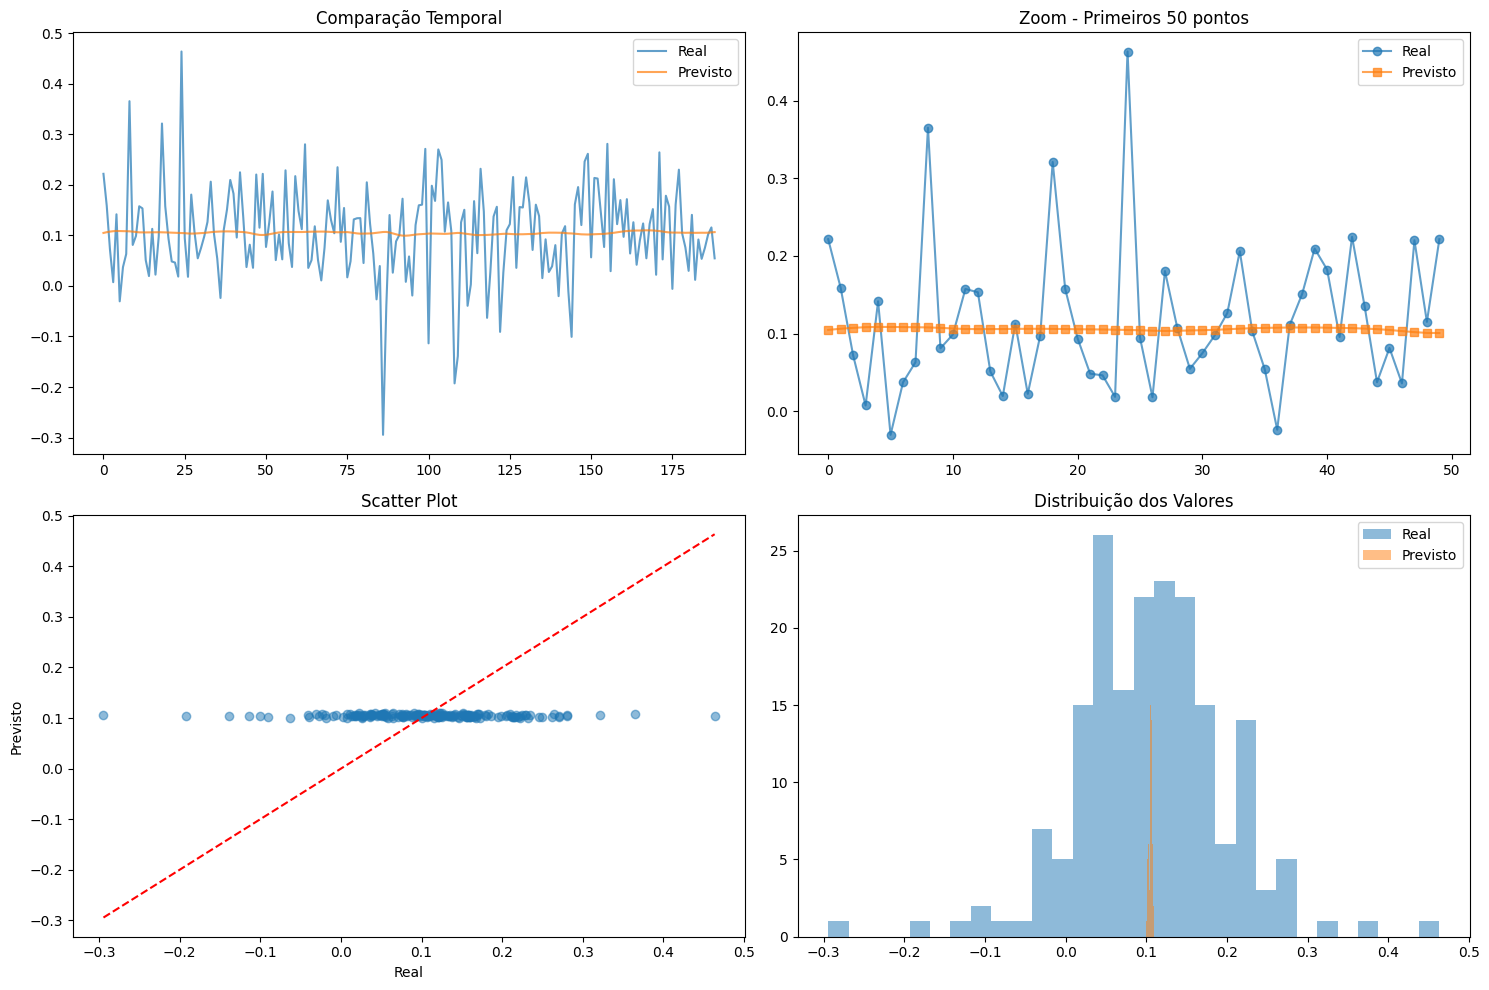

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Série temporal
axes[0,0].plot(y_teste, label='Real', alpha=0.7)
axes[0,0].plot(previsoes, label='Previsto', alpha=0.7)
axes[0,0].set_title('Comparação Temporal')
axes[0,0].legend()

# Plot 2: Primeiros 50 pontos (zoom)
axes[0,1].plot(y_teste[:50], 'o-', label='Real', alpha=0.7)
axes[0,1].plot(previsoes[:50], 's-', label='Previsto', alpha=0.7)
axes[0,1].set_title('Zoom - Primeiros 50 pontos')
axes[0,1].legend()

# Plot 3: Scatter
axes[1,0].scatter(y_teste, previsoes, alpha=0.5)
axes[1,0].plot([y_teste.min(), y_teste.max()], 
                [y_teste.min(), y_teste.max()], 'r--')
axes[1,0].set_title('Scatter Plot')
axes[1,0].set_xlabel('Real')
axes[1,0].set_ylabel('Previsto')

# Plot 4: Distribuições
axes[1,1].hist(y_teste, alpha=0.5, label='Real', bins=30)
axes[1,1].hist(previsoes, alpha=0.5, label='Previsto', bins=30)
axes[1,1].set_title('Distribuição dos Valores')
axes[1,1].legend()
    
plt.tight_layout()
plt.show()

## Entendendo a LIB

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np

In [36]:
ticker = yf.Ticker('PETR4.SA')

In [37]:
hist = ticker.history(period='max')

In [38]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-02:00,1.121323,1.121323,1.121323,1.121323,35389440000,0.0,0.0
2000-01-04 00:00:00-02:00,1.059292,1.059292,1.059292,1.059292,28861440000,0.0,0.0
2000-01-05 00:00:00-02:00,1.048604,1.048604,1.048604,1.048604,43033600000,0.0,0.0
2000-01-06 00:00:00-02:00,1.044977,1.044977,1.044977,1.044977,34055680000,0.0,0.0
2000-01-07 00:00:00-02:00,1.049749,1.049749,1.049749,1.049749,20912640000,0.0,0.0
...,...,...,...,...,...,...,...
2025-12-26 00:00:00-03:00,30.309999,30.430000,30.120001,30.410000,20178600,0.0,0.0
2025-12-29 00:00:00-03:00,30.559999,30.809999,30.520000,30.730000,20588100,0.0,0.0
2025-12-30 00:00:00-03:00,30.799999,30.959999,30.650000,30.820000,16880600,0.0,0.0


In [39]:
# Informações detalhadas
info = ticker.info

# Exemplos de campos disponíveis:
print(f"Nome: {info.get('longName')}")
print(f"Setor: {info.get('sector')}")
print(f"Market Cap: {info.get('marketCap')}")
print(f"P/L: {info.get('trailingPE')}")
print(f"Beta: {info.get('beta')}")

Nome: Petróleo Brasileiro S.A. - Petrobras
Setor: Energy
Market Cap: 398289141760
P/L: 4.973154
Beta: -0.032


In [40]:
# Demonstrativos financeiros
financials = ticker.financials  # DRE anual
quarterly_financials = ticker.quarterly_financials  # DRE trimestral

# Balanço patrimonial
balance_sheet = ticker.balance_sheet
quarterly_balance_sheet = ticker.quarterly_balance_sheet

# Fluxo de caixa
cashflow = ticker.cashflow
quarterly_cashflow = ticker.quarterly_cashflow

# Exemplo de uso
print("Receita Total (últimos 4 anos):")
print(financials.loc['Total Revenue'])

Receita Total (últimos 4 anos):
2024-12-31    9.141600e+10
2023-12-31    1.024090e+11
2022-12-31    1.244740e+11
2021-12-31    8.396600e+10
Name: Total Revenue, dtype: float64


In [41]:
# Download de múltiplas ações
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA"]
data = yf.download(tickers, start="2023-01-01", end="2024-01-01")

# Acessando dados específicos
precos_fechamento = data['Close']
volumes = data['Volume']

# Comparando retornos
retornos = precos_fechamento.pct_change()
print(retornos.describe())

/var/folders/vl/2xv77p5n31xclsdwyq7kgg3r0000gn/T/ipykernel_2646/653885830.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  3 of 3 completed

Ticker    ITUB4.SA    PETR4.SA    VALE3.SA
count   247.000000  247.000000  247.000000
mean      0.001617    0.003216   -0.000124
std       0.014733    0.020053    0.016728
min      -0.038697   -0.066050   -0.046223
25%      -0.007986   -0.007394   -0.010061
50%       0.001270    0.002843    0.000154
75%       0.011034    0.015236    0.009066
max       0.082688    0.061564    0.058543


In [42]:
# Períodos válidos
periods = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

# Intervalos válidos para dados intraday
intervals = ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

# Exemplo: dados de 5 minutos dos últimos 5 dias
data_intraday = ticker.history(period="5d", interval="5m")

In [43]:
data_intraday

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-12-29 10:00:00-03:00,30.559999,30.690001,30.559999,30.670000,144400,0.0,0.0
2025-12-29 10:05:00-03:00,30.660000,30.709999,30.639999,30.700001,385000,0.0,0.0
2025-12-29 10:10:00-03:00,30.700001,30.740000,30.660000,30.690001,439800,0.0,0.0
2025-12-29 10:15:00-03:00,30.680000,30.690001,30.610001,30.660000,238600,0.0,0.0
2025-12-29 10:20:00-03:00,30.650000,30.660000,30.629999,30.650000,172300,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-06 16:35:00-03:00,29.740000,29.740000,29.680000,29.690001,564200,0.0,0.0
2026-01-06 16:40:00-03:00,29.690001,29.700001,29.670000,29.690001,1081100,0.0,0.0
2026-01-06 16:45:00-03:00,29.680000,29.700001,29.650000,29.650000,654400,0.0,0.0


In [2]:
import pickle
from keras.models import load_model

# Verificar modelo
modelo = load_model('models/modelo_disney_lstm.h5', compile=False)
print(f"Modelo espera input shape: {modelo.input_shape}")

# Verificar scaler
with open('data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print(f"Scaler tem {scaler.n_features_in_} features")

Modelo espera input shape: (None, 60, 1)
Scaler tem 4 features


In [3]:
# fix_scaler.py
import pickle
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

print("🔧 Recriando scaler para 1 feature...")

# Baixar dados
df = yf.download('DIS', start='2018-01-01', end='2024-07-20', progress=False)

# Criar scaler apenas com Close
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df[['Close']].values)

# Salvar
with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Scaler atualizado: {scaler.n_features_in_} feature(s)")

🔧 Recriando scaler para 1 feature...


/var/folders/vl/2xv77p5n31xclsdwyq7kgg3r0000gn/T/ipykernel_36647/3055072734.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('DIS', start='2018-01-01', end='2024-07-20', progress=False)


✅ Scaler atualizado: 1 feature(s)
